# Imports

In [1]:
%load_ext autoreload
%autoreload 2
# from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
# Configure JAX for better performance
jax.config.update("jax_enable_x64", False)  # Use float32 for better GPU performance
# jax.config.update("jax_platforms", "cuda")  # Prefer GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

# Disable XLA optimizations that might cause timing issues
os.environ['XLA_FLAGS'] = '--xla_gpu_triton_gemm_any=false'

import sparse
from natsort import natsorted
from src.utils import io_dict_to_hdf5 as ioh5
from src.utils.plot_utils import *
from src.simulation.vnc_sim import *
from src.utils.path_utils import *
from omegaconf import OmegaConf
from tqdm.auto import tqdm
# Ensure custom resolvers are registered
# This is important when loading saved configs that contain custom interpolations
from src.utils.path_utils import register_custom_resolvers
register_custom_resolvers()


def print_pytree(pytree):
   """
   path_filter: function that takes key_path tuple and returns True/False
   """
   def process_leaf(key_path, leaf):
      print(f"Key Path: {key_path[0]}, Leaf: {leaf.shape}")

   return jax.tree.map_with_path(process_leaf, pytree)

def print_dict_shapes(data, prefix="", max_depth=10, current_depth=0):
   """
   Recursively print shapes for arrays and values for other types in a dictionary.
   
   Args:
      data: Dictionary or other data structure to inspect
      prefix: String prefix for indentation
      max_depth: Maximum recursion depth to prevent infinite loops
      current_depth: Current recursion depth
   """
   import jax.numpy as jnp
   import numpy as np
   
   if current_depth > max_depth:
      print(f"{prefix}... (max depth reached)")
      return
   
   if isinstance(data, dict):
      for key, value in data.items():
         print(f"{prefix}{key}:")
         print_dict_shapes(value, prefix + "  ", max_depth, current_depth + 1)
   
   elif isinstance(data, (list, tuple)):
      print(f"{prefix}Type: {type(data).__name__}, Length: {len(data)}")
      if len(data) > 0:
         print(f"{prefix}First element:")
         print_dict_shapes(data[0], prefix + "  ", max_depth, current_depth + 1)
         if len(data) > 1:
               print(f"{prefix}... ({len(data)-1} more elements)")
   
   elif hasattr(data, 'shape'):  # Arrays (JAX, NumPy, etc.)
      print(f"{prefix}Type: {type(data).__name__}, Shape: {data.shape}, Dtype: {data.dtype}")
   
   elif isinstance(data, (int, float, bool, str)):
      print(f"{prefix}Type: {type(data).__name__}, Value: {data}")
   
   elif hasattr(data, '__dict__'):  # Objects with attributes
      print(f"{prefix}Type: {type(data).__name__}")
      for attr_name in dir(data):
         if not attr_name.startswith('_'):  # Skip private attributes
               try:
                  attr_value = getattr(data, attr_name)
                  if not callable(attr_value):  # Skip methods
                     print(f"{prefix}  {attr_name}:")
                     print_dict_shapes(attr_value, prefix + "    ", max_depth, current_depth + 1)
               except:
                  print(f"{prefix}  {attr_name}: <unable to access>")
   
   else:
      print(f"{prefix}Type: {type(data).__name__}, Value: {str(data)[:100]}{'...' if len(str(data)) > 100 else ''}")

In [5]:
experiment = 'DNb08_Stim_Prune'
version = 'hyak'
# base_dir = Path(f'/gscratch/portia/eabe/Pugliese_2025/{experiment}/{version}')
base_dir = Path(f'/data/users/eabe/Pugliese_2025/{experiment}/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    print(n, run_cfg)

# ###### Load and update config with specified paths template ###### 

cfg_num = -2
# print(f'\n📁 Loading config {cfg_num}: {run_cfg_list[cfg_num]}')

# NEW APPROACH: Load config and replace paths using glados.yaml template
cfg = load_config_with_path_template(
    config_path=run_cfg_list[cfg_num],
    paths_template="glados",    # Use glados.yaml for local paths
    experiment=experiment,      # This will override if needed
    version=version,           # Use debug version locally instead of hyak
)

print(f'✅ Loaded experiment: {cfg.experiment.name}')

# Convert string paths to Path objects and create directories
try:
    cfg.paths = convert_dict_to_path(cfg.paths)
    print("✅ Successfully converted all paths to Path objects and created directories")
except Exception as e:
    print(f"⚠️  Warning: Could not convert all paths: {e}")
    print("Proceeding with string paths and manual directory creation...")
    # If conversion fails, create the directories manually
    for key, path_str in cfg.paths.items():
        if key != 'user' and isinstance(path_str, str):
            path_obj = Path(path_str)
            path_obj.mkdir(parents=True, exist_ok=True)
            cfg.paths[key] = path_obj

checkpoint_dir = None
if cfg.sim.enable_checkpointing and hasattr(cfg, 'paths'):
    checkpoint_dir = Path(cfg.paths.ckpt_dir) / "checkpoints"
# print(f"\n🎯 Final paths configuration:")
# for key, value in cfg.paths.items():
#     print(f"   {key}: {value}")

0 /data/users/eabe/Pugliese_2025/DNb08_Stim_Prune/hyak/run_id=28357547/logs/run_config.yaml
1 /data/users/eabe/Pugliese_2025/DNb08_Stim_Prune/hyak/run_id=28851757/logs/run_config.yaml
2 /data/users/eabe/Pugliese_2025/DNb08_Stim_Prune/hyak/run_id=28920181/experiment.seed=1/logs/run_config.yaml
3 /data/users/eabe/Pugliese_2025/DNb08_Stim_Prune/hyak/run_id=28920181/experiment.seed=2/logs/run_config.yaml
📁 Loading config from: /data/users/eabe/Pugliese_2025/DNb08_Stim_Prune/hyak/run_id=28920181/experiment.seed=1/logs/run_config.yaml
✅ Loaded experiment: DNb08_Stim_Prune
✅ Successfully converted all paths to Path objects and created directories


In [6]:
print("Loading network configuration...")
W_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)
# Prepare parameters
neuron_params = prepare_neuron_params(cfg, W_table, cfg.paths.ckpt_dir / 'neuron_params.h5')
# neuron_params = prepare_neuron_params(cfg, W_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
sim_config = parse_simulation_config(cfg)

print_pytree(neuron_params)

Loading network configuration...
Loaded neuron parameters from /data/users/eabe/Pugliese_2025/DNb08_Stim_Prune/hyak/run_id=28920181/experiment.seed=1/ckpt/neuron_params.h5
Key Path: .W, Leaf: (4604, 4604)
Key Path: .tau, Leaf: (512, 4604)
Key Path: .a, Leaf: (512, 4604)
Key Path: .threshold, Leaf: (512, 4604)
Key Path: .fr_cap, Leaf: (512, 4604)
Key Path: .input_currents, Leaf: (1, 512, 4604)
Key Path: .seeds, Leaf: (512, 2)
Key Path: .exc_dn_idxs, Leaf: (933,)
Key Path: .inh_dn_idxs, Leaf: (385,)
Key Path: .exc_in_idxs, Leaf: (1484,)
Key Path: .inh_in_idxs, Leaf: (1658,)
Key Path: .mn_idxs, Leaf: (144,)
Key Path: .W_mask, Leaf: (512, 4604, 4604)


NeuronParams(W=None, tau=None, a=None, threshold=None, fr_cap=None, input_currents=None, seeds=None, exc_dn_idxs=None, inh_dn_idxs=None, exc_in_idxs=None, inh_in_idxs=None, mn_idxs=None, W_mask=None)

In [6]:
jnp.where(neuron_params.W_mask[0,0] & ~mn_mask)[0]

Array([], shape=(0,), dtype=int32)

In [7]:
jnp.where(neuron_params.W_mask[0,:,0] & ~mn_mask)

(Array([], shape=(0,), dtype=int32),)

In [6]:
results = sparse.load_npz(checkpoint_dir / f"results_checkpoint_batch_{checkpoint_dict['batch_index']}/batch_{checkpoint_dict['batch_index']}.npz").todense().astype(np.float32)


# Load results

In [92]:
from src.utils.sim_utils import compute_oscillation_score, neuron_oscillation_score

results = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_Rs.npz").todense().astype(np.float32)
# results = sparse.load_npz('/data/users/eabe/Pugliese_2025/prune_test/hyak/run_id=27996612/ckpt/prune_test_mini_circuits.npz').todense().astype(np.float32)
min_circuit = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_mini_circuits.npz").todense()

In [ ]:
neuron_params_single = jax.tree.map(lambda x: x[9], neuron_params)
print_pytree(neuron_params_single)


In [59]:
exc_dn_idxs, inh_dn_idxs, exc_in_idxs, inh_in_idxs, mn_idxs = extract_shuffle_indices(W_table)


In [49]:
del neuron_params
gc.collect()
jax.clear_caches()

In [ ]:
W_mask = min_circuit[param_idx, :, None] * min_circuit[param_idx, None, :]
jnp.where(W_mask & ~mn_mask)[0]

Array([  86,   86,   86,   86,   86,   86,  693,  693,  693,  693,  693,
        693, 1211, 1211, 1211, 1211, 1211, 1211, 1579, 1579, 1579, 1579,
       1579, 1579, 2534, 2534, 2534, 2534, 2534, 2534, 4458, 4458, 4458,
       4458, 4458, 4458], dtype=int32)

In [85]:
param_idx = 9
stim_idx = 0
W_mask_new = jnp.ones((min_circuit.shape[-1],min_circuit.shape[-1]), dtype=jnp.bool_)
W_mask_new = (W_mask_new * min_circuit[param_idx, :, None] * min_circuit[param_idx, None, :]).astype(jnp.bool_)
jnp.where(W_mask_new & ~mn_mask)[0]
neuron_params_single.tau,neuron_params_single.a,neuron_params_single.threshold,neuron_params_single.fr_cap,neuron_params_single.input_currents[param_idx]*2,

(Array([0.02389682, 0.01815102, 0.02244319, ..., 0.0181357 , 0.02148832,
        0.02064551], dtype=float32),
 Array([0.02151372, 0.01700386, 0.04764691, ..., 7.706089  , 4.3621635 ,
        4.0351987 ], dtype=float32),
 Array([365.9173   , 446.7128   , 148.4126   , ...,   1.2389305,
          1.6549523,   2.2148035], dtype=float32),
 Array([214.88704, 215.78058, 198.13695, ..., 202.02287, 199.36125,
        214.48334], dtype=float32),
 Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [83]:
param_idx = 9
stim_idx = 0
W_mask_new = jnp.ones((min_circuit.shape[-1],min_circuit.shape[-1]), dtype=jnp.bool_)
W_mask_new = (W_mask_new * min_circuit[param_idx, :, None] * min_circuit[param_idx, None, :]).astype(jnp.bool_)
key = jax.random.PRNGKey(9 + 12345)
W_reweighted = reweight_connectivity(
    W_mask_new, 
    sim_params.exc_multiplier, 
    sim_params.inh_multiplier
)

# Run the final simulation with pruned network
final_results = run_single_simulation(
    W_reweighted,
    neuron_params_single.tau,
    neuron_params_single.a, 
    neuron_params_single.threshold,
    neuron_params_single.fr_cap,
    neuron_params_single.input_currents[param_idx]*2,
    sim_params.noise_stdv,
    sim_params.t_axis,
    sim_params.T,
    sim_params.dt,
    sim_params.pulse_start,
    sim_params.pulse_end,
    sim_params.r_tol,
    sim_params.a_tol,
    key
)

Text(0.5, 1.0, 'Motor Neurons')

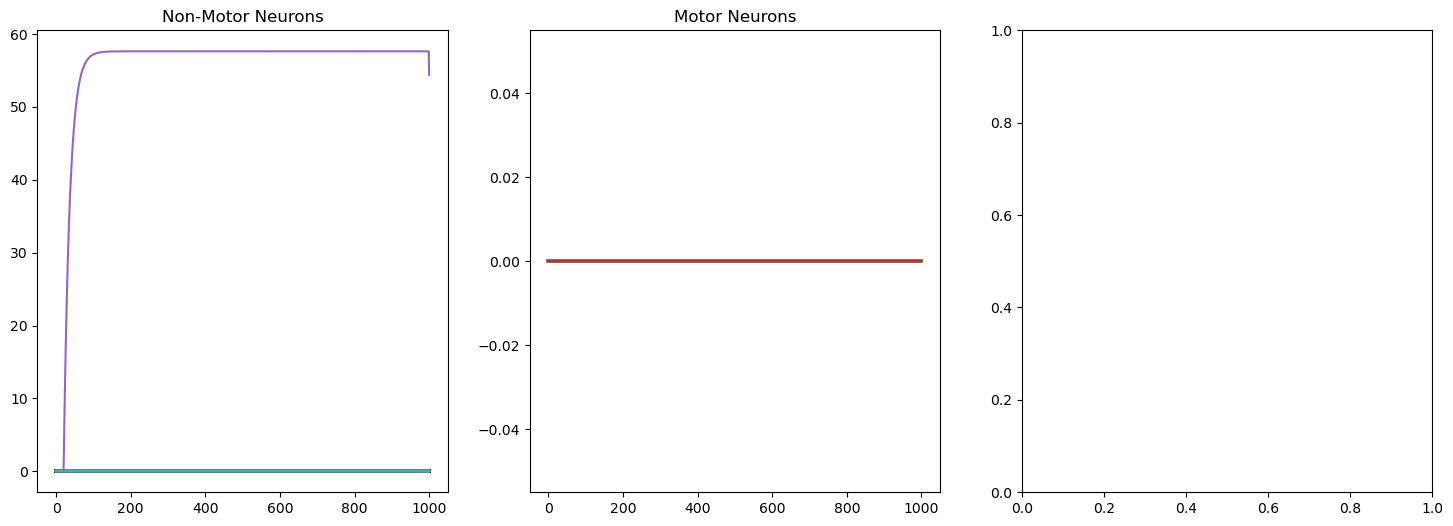

In [84]:
R = final_results#[0,9]
w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
# 10093 = bdn2, 10707 = exc 1, 11751 = exc 2, 13905 = inh 1
# nonmns_idxs = w_table.loc[(w_table["bodyId"]==10093) | (w_table["bodyId"]==10707) | (w_table["bodyId"]==11751) | (w_table["bodyId"]==13905)].index
# mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)
nonmns_idxs = jnp.where(~mn_mask)[0]
mn_idxs = jnp.where(mn_mask)[0]

fig, axs = plt.subplots(1,3, figsize=(18, 6))
for i in nonmns_idxs:
    axs[0].plot(R[i])
axs[0].set_title("Non-Motor Neurons")
for i in mn_idxs:
    axs[1].plot(R[i])
axs[1].set_title("Motor Neurons")

Array(0.10858517, dtype=float32)

In [10]:
min_circuit = jnp.stack([((jnp.sum(results[:,n],axis=-1)>0) & ~mn_mask) for n in range(results.shape[1])],axis=1)
min_circuit.shape
[jnp.where(min_circuit[0,n] & ~mn_mask)[0] for n in range(min_circuit.shape[1])]
# sparse.save_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_mini_circuits.npz", sparse.COO.from_numpy(min_circuit))


[Array([  31,  277,  617, 1167], dtype=int32),
 Array([  31,  277,  617, 1167], dtype=int32)]

In [25]:
(min_circuit[9, :, None] * min_circuit[9, None, :]).shape

(4604, 4604)

In [31]:
jnp.where(neuron_params.W_mask[9,0,:] & ~mn_mask)[0]

Array([], shape=(0,), dtype=int32)

In [ ]:
W_mask_init = jnp.ones((cfg.experiment.n_replicates,min_circuit.shape[-1],min_circuit.shape[-1]), dtype=jnp.bool_)
idx = 9
W_mask_new = (W_mask_init * min_circuit[idx, :, None] * min_circuit[idx, None, :]).astype(jnp.bool_)



In [33]:
jnp.where(W_mask_new[0,:] & ~mn_mask)[0]

Array([  86,   86,   86,   86,   86,   86,  693,  693,  693,  693,  693,
        693, 1211, 1211, 1211, 1211, 1211, 1211, 1579, 1579, 1579, 1579,
       1579, 1579, 2534, 2534, 2534, 2534, 2534, 2534, 4458, 4458, 4458,
       4458, 4458, 4458], dtype=int32)

In [93]:
from src.utils.sim_utils import compute_oscillation_score
clip_start = 250# int(sim_params.pulse_start / sim_params.dt) + 200
def compute_osc_score_all(R, mn_mask, clip_start=250):
    # Get active MN activity using JAX-compatible approach
    max_frs = jnp.max(R[..., clip_start:], axis=-1)
    active_mask = ((max_frs > 0.01) & mn_mask)

    # Compute oscillation score
    oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)
    return oscillation_score


# osc_score_all = osc_vmap(results[0], mn_mask, clip_start)
osc_score_all = []
for replicate in tqdm(range(results.shape[1])):
    osc_score = compute_osc_score_all(results[0,replicate], mn_mask, clip_start=clip_start)
    osc_score_all.append(osc_score)
osc_score_all = jnp.array(osc_score_all)

  0%|          | 0/512 [00:00<?, ?it/s]

In [19]:
n_neurons_mini = jnp.array([len(jnp.where(min_circuit[n] & ~mn_mask)[0]) for n in range(min_circuit.shape[0])])
# jnp.where(min_circuit[0])

In [22]:
min_circuit.shape

(4, 4604)

In [12]:
jnp.where(min_circuit[0] & ~mn_mask)[0]

Array([  86,  277,  617, 1211, 2534, 4458], dtype=int32)

In [90]:
[jnp.where(min_circuit[n] & ~mn_mask)[0] for n in range(min_circuit.shape[0])]

[Array([  86,  277,  617, 1211, 2534, 4458], dtype=int32),
 Array([ 277,  280,  617,  630,  693,  696, 1211, 4458], dtype=int32),
 Array([  86,  277,  617,  693, 1211, 4458], dtype=int32),
 Array([ 280,  617,  693, 1167, 1211, 4458], dtype=int32),
 Array([  86,  277,  617,  693, 1211, 4458], dtype=int32),
 Array([  86,  277,  617,  693, 1078, 1211, 4458], dtype=int32),
 Array([  86,  277,  617,  693, 1211, 4458], dtype=int32),
 Array([  86,  277,  617,  693, 1211, 2275], dtype=int32),
 Array([  86,  277,  617,  693, 1211, 4458], dtype=int32),
 Array([  86,  693, 1211, 1579, 2534, 4458], dtype=int32),
 Array([ 280,  617,  693, 1167, 1211, 4458], dtype=int32),
 Array([  86,  277,  617,  693, 1211, 4458], dtype=int32),
 Array([  86,  280,  614,  617,  693, 1078, 1208, 1211, 1921, 2409, 4458],      dtype=int32),
 Array([ 495, 1078, 1211, 2275, 2591, 4456, 4458], dtype=int32),
 Array([  86,  280,  617,  693, 1211, 2409, 4458], dtype=int32),
 Array([ 277,  617, 1167, 1211, 2534, 2591, 4458],

In [26]:
jnp.unique(jnp.concatenate([jnp.where(min_circuit[n] & ~mn_mask)[0] for n in range(min_circuit.shape[0])],axis=0),return_counts=True)

(Array([  31,   86,  277,  617, 1167], dtype=int32),
 Array([1, 1, 3, 4, 3], dtype=int32))

In [97]:
len(jnp.where(osc_score_all<0.5)[0])/512

0.076171875

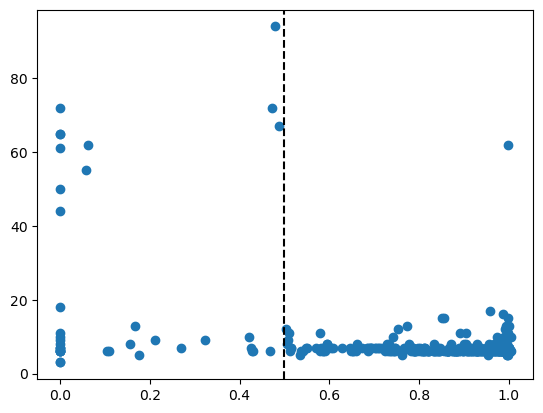

In [20]:
plt.scatter(osc_score_all, n_neurons_mini )
plt.axvline(x=0.5,c='k',ls='--')

In [7]:
results.shape

(1, 1024, 4604, 1001)

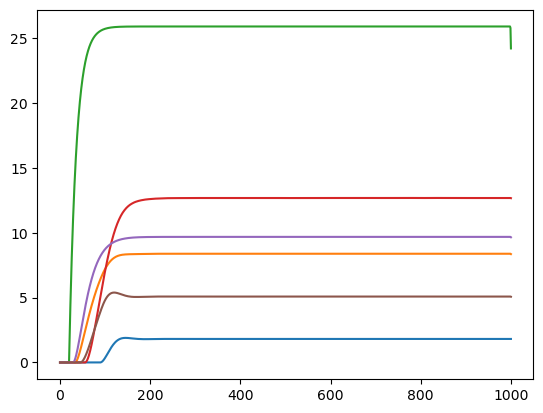

In [96]:
n = 9
plt.plot(results[0,n,min_circuit[n]].T)

In [ ]:
check_ind = jnp.where(osc_score_all<0.5)[0]
# for n in range(len(check_ind)):
for n in range(10):
    R = results[0][check_ind[n]]
    print(osc_score_all[check_ind[n]])
    w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
    # 10093 = bdn2, 10707 = exc 1, 11751 = exc 2, 13905 = inh 1
    nonmns_idxs = w_table.loc[(w_table["bodyId"]==10093) | (w_table["bodyId"]==10707) | (w_table["bodyId"]==11751) | (w_table["bodyId"]==13905)].index
    mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)

    fig, axs = plt.subplots(1,3, figsize=(18, 6))
    for i in nonmns_idxs:
        axs[0].plot(R[i])
    axs[0].set_title("Non-Motor Neurons")
    for i in mn_idxs:
        axs[1].plot(R[i])
    axs[1].set_title("Motor Neurons")


# scores001 = []
# for i in range(results.shape[1]):
#     R = results[0][i]
#     max_frs = jnp.max(R, axis=-1)
#     active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
#     activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index
#     score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
#     scores001.append(score)
# scores001 = jnp.concatenate(scores001, axis=-1)
# axs[2].hist(scores001, bins=50, density=True)
# plt.savefig("/data/users/eabe/Pugliese_2025/BND2_Stim_Test/debug/run_id=Testing/sim.noise=True/figures/Example_R.png", dpi=300)
plt.show()


0.49949652
0.499279
0.16256762
0.23966448
0.49967083
0.0
0.49933738
0.21912007
0.43483755
0.49824634
0.49943382
0.208418
0.49843386
0.49899223
0.0
0.49852532
0.48537502
0.4008642
0.49889615
0.4985739
0.49905136
0.4520758


/tmp/ipykernel_3512079/2413706698.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,3, figsize=(18, 6))


0.39297423
0.49921238
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.10841509
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3931809
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4753139
0.31009588
0.0
0.45856804
0.4985162
0.49649143
0.49801844
0.45881352
0.4981954
0.4981259
0.49949148
0.49832037
0.0
0.3834647
0.0
0.41936263
0.0
0.0
0.0
0.0
0.0
0.0
0.3028941
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.12709789
0.121000275
0.0
0.0
0.0
0.04016412
0.0
0.0
0.22171937
0.2765023
0.0
0.0
0.0
0.0
0.0300802
0.16260664
0.0
0.30829886
0.0
0.0
0.056725375
0.11421431
0.24252735
0.0
0.0
0.4726712
0.0
0.0
0.306064
0.16582863
0.0
0.05823619
0.33847177
0.0
0.06730034
0.029685313
0.20184675
0.0
0.0
0.16382498
0.075210854
0.061827753
0.056185097
0.0
0.0

KeyboardInterrupt: 

In [ ]:
from src.utils.sim_utils import compute_oscillation_score, neuron_oscillation_score
clip_start = 250# int(sim_params.pulse_start / sim_params.dt) + 200
def compute_osc_score_all(R, mn_mask, clip_start=250):
    # Get active MN activity using JAX-compatible approach
    max_frs = jnp.max(R, axis=-1)
    active_mask = ((max_frs > 0) & mn_mask)

    # Compute oscillation score
    oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)
    return oscillation_score


# osc_score_all = osc_vmap(results[0], mn_mask, clip_start)
osc_score_all = []
for replicate in tqdm(range(results.shape[1])):
    osc_score = compute_osc_score_all(results[0,replicate], mn_mask, clip_start=clip_start)
    osc_score_all.append(osc_score)
osc_score_all = jnp.array(osc_score_all)

In [ ]:
results.shape, active_mask.shape

In [ ]:
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 100

scores001 = []
for i in range(results001.shape[1]):
    R = results001[0][i]
    max_frs = jnp.max(R, axis=-1)
    active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
    activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index
    score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
    scores001.append(score)
scores01 = []
for i in range(results01.shape[1]):
    R = results01[0][i]
    max_frs = jnp.max(R, axis=-1)
    active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
    activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index
    score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
    scores01.append(score)
scores1 = []
for i in range(results1.shape[1]):
    R = results1[0][i]
    max_frs = jnp.max(R, axis=-1)
    active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
    activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index
    score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
    scores1.append(score)
scores10 = []
for i in range(results10.shape[1]):
    R = results10[0][i]
    max_frs = jnp.max(R, axis=-1)
    active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
    activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index
    score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
    scores10.append(score)
    
    
    
# score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
# print(f"Score: {jnp.nanmean(score)}, Frequency: {jnp.nanmean(frequency)}")

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(12, 12))
axs = axs.flatten()
axs[0].hist(jnp.concatenate(scores001, axis=-1), bins=25)
axs[0].set_xlabel("Oscillation Score")
axs[0].set_title("Noise=0.01")
axs[1].hist(jnp.concatenate(scores01, axis=-1), bins=25)
axs[1].set_xlabel("Oscillation Score")
axs[1].set_title("Noise=0.1")
axs[2].hist(jnp.concatenate(scores1, axis=-1), bins=25)
axs[2].set_xlabel("Oscillation Score")
axs[2].set_title("Noise=1")
axs[3].hist(jnp.concatenate(scores10, axis=-1), bins=25)
axs[3].set_xlabel("Oscillation Score")
axs[3].set_title("Noise=10")
plt.savefig("/data/users/eabe/Pugliese_2025/BND2_Stim_Test/debug/run_id=noisy_inputs/figures/oscillation_scores.png", dpi=300)

# Testing Shuffle

In [ ]:
params, config = load_vnc_net(cfg)
simulator = OptimizedSimulator(params, config)
# W, W_table = load_connectivity(cfg)

In [ ]:
work_queue = simulator._create_work_queue()

In [ ]:
from src.utils.shuffle_utils import shuffle_W

In [ ]:
newkey, key = jax.random.split(work_queue[0]['seed'])
idxs = params.inh_dn_idxs
W = params.W
W_shuff = shuffle_W(W, key, idxs, independent=True)


# Plot Results

In [13]:
np.where(np.all(np.sum(results,axis=-1)==0,axis=-1))

(array([0]), array([1]))

In [ ]:
R = results[0][0]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


## Testing osc score

In [ ]:
results = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_Rs.npz").todense().astype(np.float32)

wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
non_mns = (wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]).values
mn_idxs = wTable.loc[wTable["class"]=="motor neuron"].index.values


In [ ]:
from scipy import signal
import numpy as np
def neuron_oscillation_score_helper_old(activity,prominence):
    activity = activity-np.min(activity)
    activity = 2 * activity/np.max(activity) - 1

    autocorr = np.correlate(activity,activity,mode="full") / np.inner(activity,activity)
    lags = signal.correlation_lags(len(activity),len(activity))
    autocorr = autocorr[lags>0]
    lags = lags[lags>0]

    peaks, peakProperties = signal.find_peaks(autocorr,height=(None,None),prominence=prominence)
    if len(peaks) > 0:
        score = np.min([np.max(peakProperties["peak_heights"]),np.max(peakProperties["prominences"])])
        frequency = 1 / peaks[np.argmax(peakProperties["prominences"])]
    else:
        score = 0
        frequency = 0

    return score, frequency

def neuron_oscillation_score_old(activity, returnFrequency=False,prominence=0.05):
    rawScore, frequency = neuron_oscillation_score_helper_old(activity,prominence)
    # normalize to sine wave of the same frequency and duration
    if rawScore == 0:
        score = 0
    else:
        refSinScore, _ = neuron_oscillation_score_helper_old(np.sin(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refCosScore, _ = neuron_oscillation_score_helper_old(np.cos(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refScore = np.max((refSinScore,refCosScore))
        score = rawScore / refScore

    if returnFrequency:
        return score, frequency
    else:
        return score

def sim_oscillation_score_old(R,activeMnIdxs,start=None,end=None,returnFrequency=False):
    """calculate oscillation score for a simulation"""
    if start is None:
        start = 0
    if end is None:
        end = -1

    if returnFrequency:
        neuronOscillationScores = []
        frequencies = []

        for j in activeMnIdxs:
            score, freq = neuron_oscillation_score_old(R[j][start:end],returnFrequency=True)
            neuronOscillationScores.append(score)
            frequencies.append(freq)
        return np.mean(neuronOscillationScores), np.nanmean(frequencies)
        
    else:
        neuronOscillationScores = [neuron_oscillation_score_old(R[j][start:end]) for j in activeMnIdxs] # scores for each neuron
        return np.mean(neuronOscillationScores) # average for the simulation
    
    

In [ ]:
R = results[0][0]
np_R = np.asarray(R)
maxFrs = np.max(np_R,axis=-1)
activeMnIdxs = mn_idxs[maxFrs[mn_idxs]>0]
plt.plot(np_R[activeMnIdxs].T)
plt.show()
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 200
print(f"Start index: {start}")
score, freq = sim_oscillation_score_old(R,activeMnIdxs,start=start,end=None,returnFrequency=True)
print(f"Score: {score}, Frequency: {freq}")

##### New Method #####
# R = results[0][0]

max_frs = jnp.max(R, axis=-1)
active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index

score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)

print(f"Score: {jnp.nanmean(score)}, Frequency: {jnp.nanmean(frequency)}")

In [ ]:
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 100
R = results
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[2]), mn_idxs)
active_mask = ((max_frs > 0) & mn_mask)

In [ ]:
from jax.scipy.signal import correlate
from src.utils.sim_utils import *

In [ ]:
activity = results[0][1][451, start:]  # Adjusted to match the original code's start index

activity = activity - jnp.min(activity, axis=-1, keepdims=True)
activity = 2 * activity / jnp.max(activity, axis=-1, keepdims=True) - 1

autocorr = autocorrelation_1d(activity)

In [ ]:
autocorr_scipy = correlate(activity, activity, mode='full', method='fft')
autocorr_scipy = autocorr_scipy/jnp.max(autocorr_scipy)
autocorr_old = np.correlate(activity,activity,mode="full") / np.inner(activity,activity)


In [ ]:
plt.plot(autocorr, label='JAX Autocorrelation')
plt.plot(autocorr_scipy, label='SciPy Autocorrelation')
plt.plot(autocorr_old, label='Old NumPy Autocorrelation')

In [ ]:
jnp.where(active_mask[0,0])

In [ ]:
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 100
R = results[0][0]

max_frs = jnp.max(R, axis=-1)
active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index

score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)

print(f"Score: {jnp.nanmean(score)}, Frequency: {jnp.nanmean(frequency)}")

# Testing Pruning

In [ ]:
from src.utils.sim_utils import neuron_oscillation_score

experiment='prune_test'
sim = 'prune_network'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", f"sim={sim}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)

def print_inds(arr, name=''):
    print(f"Indices for {name}: {jnp.where(arr)[0].shape}")
    return jnp.where(arr)[-1]

## full pipeline testing

In [ ]:
W_table = load_wTable(cfg.experiment.dfPath)

n_stim_configs = len(cfg.experiment.stimNeurons)

# Prepare parameters
neuron_params = prepare_neuron_params(cfg, W_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
sim_config = parse_simulation_config(cfg)


In [ ]:
total_sims = sim_params.n_stim_configs * sim_params.n_param_sets
n_devices = jax.device_count()

# Calculate batch size
batch_size = sim_config.batch_size
if batch_size is None:
    batch_size = calculate_optimal_batch_size(
        sim_params.n_neurons, len(sim_params.t_axis), n_devices
    )

# Adjust batch size for multiple devices
if n_devices > 1:
    batch_size = (batch_size // n_devices) * n_devices
    if batch_size == 0:
        batch_size = n_devices

# Get batch processing function
batch_func = get_batch_function(sim_config)

# Create parallel version for multiple devices
if n_devices > 1:
    batch_func = pmap(batch_func, axis_name="device", in_axes=(None, None, 0))

print(f"Running {total_sims} {sim_config.sim_type} simulations with batch size {batch_size} on {n_devices} device(s)")


In [ ]:

# Pre-compute static values that won't change during the loop
oscillation_threshold_val = float(sim_config.oscillation_threshold)
clip_start_val = int(sim_params.pulse_start / sim_params.dt) + 200

# Create a version of update_single_sim_state with static args baked in
def update_state_with_static_args(state, R, mn_mask):
    jax.debug.print("W_mask shape: {W_mask.shape}", W_mask=state.W_mask)
    return update_single_sim_state(state, R, mn_mask, oscillation_threshold_val, clip_start_val)

# Apply JIT to the wrapper function (not the original)
jitted_update = jax.jit(update_state_with_static_args)

# Now vmap this wrapper with only the traced arguments
batch_update = jax.vmap(
    jitted_update, 
    in_axes=(0, 0, 0)  # state, R, mn_mask - all batched
)

# Create parallel versions for multiple devices
if n_devices > 1:
    batch_update = pmap(batch_update, axis_name="device", in_axes=(0, 0, 0))

# Rest of the function...
all_results = []
n_batches = (total_sims + batch_size - 1) // batch_size

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, total_sims)
    actual_batch_size = end_idx - start_idx
    
    batch_indices = jnp.arange(start_idx, end_idx)
    
    # Pad batch_indices if necessary for pmap
    if n_devices > 1 and len(batch_indices) < batch_size:
        pad_size = batch_size - len(batch_indices)
        batch_indices = jnp.concatenate([
            batch_indices, 
            jnp.repeat(batch_indices[-1], pad_size)
        ])
    
    mn_idxs = neuron_params.mn_idxs
    
    # Initialize state for this batch
    current_batch_size = len(batch_indices)
    state = initialize_pruning_state(neuron_params, sim_params, current_batch_size)

    # Reshape state for pmap if using multiple devices
    if n_devices > 1:
        state = reshape_state_for_pmap(state, n_devices)
        batch_indices = batch_indices.reshape(n_devices, -1)

    # Main pruning loop
    iteration = 0
    
    # Clear GPU memory before processing
    jax.clear_caches()
    
    # while True:
    # Check convergence condition
    all_converged = jnp.all(state.min_circuit)
    
    if all_converged or (iteration >= sim_config.max_pruning_iterations):
        break
        
    start_time = time.time()
    print(f"Iteration {iteration}")
    
    # Update neuron parameters W_mask based on the current state
    if n_devices > 1:
        flat_W_mask = reshape_state_from_pmap(state).W_mask
        neuron_params = neuron_params._replace(W_mask=flat_W_mask)
    else:
        neuron_params = neuron_params._replace(W_mask=state.W_mask)

    # Run simulation
    batch_results = batch_func(neuron_params, sim_params, batch_indices)
    
    # Create mn_mask and broadcast to batch dimensions
    mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), mn_idxs)
    
    if n_devices > 1:
        # For pmap, broadcast to (n_devices, batch_per_device, n_neurons)
        batch_per_device = batch_indices.shape[1]
        mn_mask_batch = jnp.broadcast_to(mn_mask, (n_devices, batch_per_device, len(mn_mask)))
    else:
        # For single device, broadcast to (batch_size, n_neurons)
        mn_mask_batch = jnp.broadcast_to(mn_mask, (batch_results.shape[0], len(mn_mask)))
        
    # Update state - now only passing traced arguments
    print("Updating state with batch results")
    print(f"W_mask shape: {state.W_mask.shape}")

In [ ]:
# print_pytree(neuron_params)
# sim_config
# print_pytree(batch_indices)

In [ ]:
state.W_mask.shape

In [ ]:
oscillation_threshold = 0.2
# Load data (this part stays on CPU)
w_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)
## Initialize parameters
neuron_params = prepare_neuron_params(cfg, w_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
all_neurons = w_table.index.to_numpy()
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
clip_start = int(cfg.sim.pulseStart / cfg.sim.dt) + 100

total_sims = sim_params.n_stim_configs * sim_params.n_param_sets
batch_size = getattr(cfg.experiment, "batch_size", None)
if batch_size is None:
    batch_size = calculate_optimal_batch_size(
        sim_params.n_neurons, len(sim_params.t_axis)
    )
    
batch_func = process_batch_prune
# Create parallel version for multiple devices
if jax.device_count() > 1:
    batch_func = pmap(batch_func, axis_name="device", in_axes=(None, None, 0))
    batch_size = (batch_size // jax.device_count()) * jax.device_count()

print(f"Running {total_sims} simulations with batch size {batch_size}")

# Process in batches
all_results = []
n_batches = (total_sims + batch_size - 1) // batch_size

# for i in range(n_batches):
i = 0 
start_idx = i * batch_size
end_idx = min((i + 1) * batch_size, total_sims)

batch_indices = jnp.arange(start_idx, end_idx)

# Pad if necessary for pmap
if jax.device_count() > 1 and len(batch_indices) < batch_size:
    pad_size = batch_size - len(batch_indices)
    batch_indices = jnp.concatenate([
        batch_indices, 
        jnp.repeat(batch_indices[-1], pad_size)
    ])


In [ ]:

mn_idxs = neuron_params.mn_idxs
all_neurons = jnp.arange(neuron_params.W.shape[-1])
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)

clip_start = int(sim_params.pulse_start / sim_params.dt) + 100
# Initialize state
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
W_mask = jnp.full((n_sims, neuron_params.W.shape[0], neuron_params.W.shape[1]), 1, dtype=jnp.float32)
interneuron_mask = jnp.full((n_sims, W_mask.shape[-1]),fill_value=False, dtype=jnp.bool_)
interneuron_mask = interneuron_mask.at[:,in_idxs].set(True)
level = jnp.zeros((n_sims,1), dtype=jnp.int32)
total_removed_neurons = jnp.full((n_sims, W_mask.shape[-1]), False, dtype=jnp.bool)
removed_stim_neurons = jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
neurons_put_back =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
prev_put_back =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
last_removed =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool) # Use False for None
min_circuit = jnp.full((n_sims,1), False)

# Initialize probabilities
exclude_mask = (~interneuron_mask)
p_arrays = jax.vmap(removal_probability)(jnp.ones(len(interneuron_mask)), exclude_mask)

# initialize pruning state
state = Pruning_state(
    W_mask=W_mask,
    interneuron_mask=interneuron_mask,
    level=level,
    total_removed_neurons=total_removed_neurons,
    removed_stim_neurons=removed_stim_neurons,
    neurons_put_back=neurons_put_back,
    prev_put_back=prev_put_back,
    last_removed=last_removed,
    remove_p=p_arrays,
    min_circuit=min_circuit,
    keys=neuron_params.seeds
)

iter_start = 0  # Starting iteration
# Main pruning loop
iteration = iter_start
max_iterations = 1  # Safety limit
while not jnp.all(min_circuit) and (iteration < max_iterations):
    start_time = time.time()
    print(f"Iteration {iteration}")
    # Update neuron parameters W_mask based on the current state
    neuron_params = neuron_params._replace(W_mask=state.W_mask)
    # Run simulation (this would call your simulation function)
    # Reshape for devices if using pmap
    if jax.device_count() > 1:
        batch_indices = batch_indices.reshape(jax.device_count(), -1)
        batch_results = batch_func(neuron_params, sim_params, batch_indices)
        batch_results = batch_results.reshape(-1, *batch_results.shape[2:])
        batch_results = batch_results[:end_idx - start_idx]  # Remove padding
    else:
        batch_results = batch_func(neuron_params, sim_params, batch_indices)
    
    n = 0 
    state = jax.vmap(update_single_sim_state, in_axes=(0, 0, None, None, None))(state, batch_results, mn_idxs, oscillation_threshold, clip_start)
    iteration += 1
    
    elapsed = time.time() - start_time
    print(f"  Total time: {elapsed:.2f} seconds")

# batch_results = jax.device_put(batch_results, jax.devices("cpu")[0])
# all_results.append(batch_results)
# print(f"Batch {i + 1}/{n_batches} completed")

# del batch_results  # Free memory
# gc.collect()  # Force garbage collection

# Combine results
# results = jnp.concatenate(all_results, axis=0)

In [ ]:

mn_idxs = neuron_params.mn_idxs
all_neurons = jnp.arange(neuron_params.W.shape[-1])
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)

clip_start = int(sim_params.pulse_start / sim_params.dt) + 100
# Initialize state
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
W_mask = jnp.full((n_sims, neuron_params.W.shape[0], neuron_params.W.shape[1]), 1, dtype=jnp.float32)
interneuron_mask = jnp.full((n_sims, W_mask.shape[-1]),fill_value=False, dtype=jnp.bool_)
interneuron_mask = interneuron_mask.at[:,in_idxs].set(True)
level = jnp.zeros((n_sims,1), dtype=jnp.int32)
total_removed_neurons = jnp.full((n_sims, W_mask.shape[-1]), False, dtype=jnp.bool)
removed_stim_neurons = jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
neurons_put_back =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
prev_put_back =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
last_removed =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool) # Use False for None
min_circuit = jnp.full((n_sims,1), False)

# Initialize probabilities
exclude_mask = (~interneuron_mask)
p_arrays = jax.vmap(removal_probability)(jnp.ones(len(interneuron_mask)), exclude_mask)

# initialize pruning state
state = Pruning_state(
    W_mask=W_mask[0],
    interneuron_mask=interneuron_mask[0],
    level=level[0],
    total_removed_neurons=total_removed_neurons[0],
    removed_stim_neurons=removed_stim_neurons[0],
    neurons_put_back=neurons_put_back[0],
    prev_put_back=prev_put_back[0],
    last_removed=last_removed[0],
    remove_p=p_arrays[0],
    min_circuit=min_circuit[0],
    keys=neuron_params.seeds[0],
)
R = batch_results[0]

In [ ]:

# Unpack state
(W_mask, interneuron_mask, level, total_removed_neurons, removed_stim_neurons,
    neurons_put_back, last_removed, remove_p, min_circuit, key) = state

# Get active MN activity using JAX-compatible approach
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)

# Compute oscillation score
oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)

# Check if oscillation is below threshold or NaN
reset_condition = (oscillation_score < oscillation_threshold) | jnp.isnan(oscillation_score)

# Identify currently silent interneurons (these will be permanently removed)
silent_interneurons = interneuron_mask & (max_frs <= 0)

key_next, subkey_continue, subkey_reset = random.split(key, 3)

# === CONTINUE BRANCH: Normal pruning (oscillation is good) ===
# Permanently remove silent interneurons
total_removed_continue = total_removed_neurons | silent_interneurons

# Update probabilities - exclude non-interneurons and removed neurons
exclude_mask_continue = (~interneuron_mask) | total_removed_continue
p_continue = removal_probability(max_frs, exclude_mask_continue)

# Sample new neuron to remove (only from available interneurons)
neuron_idx_continue = jax_choice(subkey_continue, jnp.arange(len(max_frs)), p_continue)

# Update removed neurons
removed_stim_continue = removed_stim_neurons.at[neuron_idx_continue].set(True)
total_removed_continue = total_removed_continue.at[neuron_idx_continue].set(True)

# Track what was removed this iteration (both silent and stimulated)
newly_silent_continue = silent_interneurons & (~total_removed_neurons)  # Only newly silent
last_removed_continue = jnp.full(last_removed.shape, False, dtype=jnp.bool_)
last_removed_continue = last_removed_continue.at[neuron_idx_continue].set(True)  # Stimulated removal
last_removed_continue = last_removed_continue | newly_silent_continue  # Add newly silent

# Update other state
level_continue = level + 1
neurons_put_back_continue = neurons_put_back  # Unchanged
min_circuit_continue = False  # Not converged yet

# === RESET BRANCH: Restore last removed and try again ===
# Restore ALL neurons from last_removed (both stimulated and those that went silent)
# This includes neurons that went silent due to the last stimulated removal

# Restore stimulated neurons from last removal
removed_stim_reset = removed_stim_neurons & (~last_removed)

# For total_removed: keep permanent removals from before last iteration, 
# add current silent neurons, but restore all last_removed neurons
permanent_before_last = total_removed_neurons & (~last_removed)
# Current silent neurons are those silent now (may include some that weren't silent before)
# But we need to be careful not to restore neurons that are currently silent due to OTHER reasons
# Only add neurons to total_removed if they are silent AND were not in last_removed
currently_silent_not_restored = silent_interneurons & (~last_removed)
total_removed_reset = permanent_before_last | currently_silent_not_restored

# Track neurons being put back - ALL neurons from last_removed
# This includes both the stimulated neuron and any neurons that went silent due to that removal
restored_neurons = last_removed  # All neurons from last_removed are being restored
neurons_put_back_reset = neurons_put_back | restored_neurons

# Now select a different neuron to remove (avoid the restored ones)
exclude_mask_reset = (~interneuron_mask) | total_removed_reset | restored_neurons
p_reset = removal_probability(max_frs, exclude_mask_reset)

# Check how many neurons are available
available_neurons_reset = jnp.sum(interneuron_mask & (~exclude_mask_reset))

# Select neuron to remove
neuron_idx_reset = jax_choice(subkey_reset, jnp.arange(len(max_frs)), p_reset)

# Only update if we have available neurons (otherwise keep current state)
should_remove_new = available_neurons_reset > 0
removed_stim_reset = jax.lax.select(
    should_remove_new,
    removed_stim_reset.at[neuron_idx_reset].set(True),
    removed_stim_reset
)
total_removed_reset = jax.lax.select(
    should_remove_new,
    total_removed_reset.at[neuron_idx_reset].set(True),
    total_removed_reset
)

# Track what was newly removed this iteration
last_removed_reset = jnp.full(last_removed.shape, False, dtype=jnp.bool_)
last_removed_reset = jax.lax.select(
    should_remove_new,
    last_removed_reset.at[neuron_idx_reset].set(True),
    last_removed_reset
)

# Add any newly silent neurons (those that are silent now but weren't in total_removed_neurons before)
# These are neurons that became silent due to current network state, not due to last removal
newly_silent_reset = silent_interneurons & (~total_removed_neurons) & (~last_removed)
last_removed_reset = last_removed_reset | newly_silent_reset

# Keep level the same (we're trying again, not progressing)
level_reset = level

# Check if we've converged - either no more neurons to remove OR we're oscillating
# Oscillation detection: if we're restoring neurons we've put back before, we're in a loop
oscillation_detected = jnp.any(restored_neurons & neurons_put_back)
min_circuit_reset = (available_neurons_reset <= 2) | oscillation_detected

# === SELECT BETWEEN BRANCHES ===
# Use jax.lax.select to choose between continue and reset results
final_total_removed = jax.lax.select(reset_condition, total_removed_reset, total_removed_continue)
final_removed_stim = jax.lax.select(reset_condition, removed_stim_reset, removed_stim_continue)
final_last_removed = jax.lax.select(reset_condition, last_removed_reset, last_removed_continue)
final_neurons_put_back = jax.lax.select(reset_condition, neurons_put_back_reset, neurons_put_back_continue)
final_level = jax.lax.select(reset_condition, level_reset, level_continue)
final_p = jax.lax.select(reset_condition, p_reset, p_continue)
final_min_circuit = jax.lax.select(reset_condition, min_circuit_reset, min_circuit_continue)

# Calculate available neurons and check for convergence
available_neurons = jnp.sum(interneuron_mask & (~final_total_removed))

# Check for oscillation: if we're in reset mode and detected oscillation, we've converged
oscillation_converged = reset_condition & final_min_circuit
size_converged = available_neurons <= 2
final_converged = oscillation_converged | size_converged

# Update W_mask to reflect removed neurons
W_mask_init = jnp.ones_like(W_mask, dtype=jnp.float32)
removed_float = final_total_removed.astype(jnp.float32)
kept_mask = 1.0 - removed_float
W_mask_new = W_mask_init * kept_mask[:, None] * kept_mask[None, :]

# Convert to scalar for jax.lax.select
final_converged_scalar = jnp.squeeze(final_converged)

# Debug information
jax.debug.print("Oscillation score: {score}", score=oscillation_score)
jax.debug.print("Reset condition (below threshold): {condition}", condition=reset_condition)
jax.debug.print("Available neurons: {count}", count=available_neurons)
jax.debug.print("Level: {level}", level=final_level)
jax.debug.print("Oscillation detected: {detected}", detected=reset_condition & (final_min_circuit & ~size_converged))
jax.debug.print("Final converged: {converged}", converged=final_converged)
jax.debug.print("Silent neurons removed: {count}", count=jnp.sum(silent_interneurons))
print('\n')

# When converged, preserve current state (don't make further changes)
state = Pruning_state(
    W_mask=jax.lax.select(final_converged_scalar, W_mask, W_mask_new),
    interneuron_mask=interneuron_mask,
    level=jax.lax.select(final_converged_scalar, level, final_level),
    total_removed_neurons=jax.lax.select(final_converged_scalar, total_removed_neurons, final_total_removed),
    neurons_put_back=jax.lax.select(final_converged_scalar, neurons_put_back, final_neurons_put_back),
    removed_stim_neurons=jax.lax.select(final_converged_scalar, removed_stim_neurons, final_removed_stim),
    last_removed=jax.lax.select(final_converged_scalar, last_removed, final_last_removed),
    remove_p=jax.lax.select(final_converged_scalar, remove_p, final_p),
    min_circuit=final_converged_scalar,
    keys=key_next,
)


In [ ]:
print_inds(~load_state.total_removed_neurons[0])

In [ ]:
exclude_inds = print_inds(exclude_mask_continue)
in_idxs.shape[0] - exclude_inds.shape[0]  # Number of interneurons left after pruning

In [ ]:
print_inds(~exclude_mask_continue), print_inds(~exclude_mask_reset), print_inds(~final_total_removed)

### Debug version

In [ ]:
def print_pytree(pytree):
    """
    path_filter: function that takes key_path tuple and returns True/False
    """
    def process_leaf(key_path, leaf):
       print(f"Key Path: {key_path[0]}, Leaf: {leaf.shape} dype: {leaf.dtype}")

    return jax.tree.map_with_path(process_leaf, pytree)
print_pytree(state)

In [ ]:
import jax
import jax.numpy as jnp
from dataclasses import dataclass
from functools import partial
from src.sim_utils import compute_oscillation_score
from src.optimized_vnc import update_params

@dataclass
class Pruning_state:
    W_mask: jnp.ndarray
    interneuron_mask: jnp.ndarray
    level: int
    total_removed_neurons: jnp.ndarray
    neurons_put_back_current: jnp.ndarray
    neurons_put_back_prev: jnp.ndarray
    removed_stim_neurons: jnp.ndarray
    last_removed: jnp.ndarray
    remove_p: jnp.ndarray
    round_complete: bool
    converged: bool
    round_number: int
    keys: jax.random.PRNGKey
    steps_in_current_round: int  # Track steps within current round
    total_iterations: int        # Track total iterations for safety

def safe_choice(key, logits, exclude_mask):
    """Safe choice function that works with vmap"""
    # Set excluded neurons to very negative logits
    safe_logits = jnp.where(exclude_mask, -1e10, logits)
    # Use gumbel trick for sampling
    gumbel_noise = jax.random.gumbel(key, safe_logits.shape)
    return jnp.argmax(safe_logits + gumbel_noise)

def removal_probability_safe(max_frs, exclude_mask):
    """Safe removal probability that works with vmap"""
    # Create base probabilities (higher firing rate = lower removal probability)
    base_probs = 1.0 / (max_frs + 1e-6)  # Add epsilon to avoid division by zero
    # Zero out excluded neurons
    probs = jnp.where(exclude_mask, 0.0, base_probs)
    # Normalize (with safety for all-zero case)
    total_prob = jnp.sum(probs)
    return jnp.where(total_prob > 0, probs / total_prob, probs)

def pruning_step_dynamic(state, R, mn_idxs, clip_start, oscillation_threshold):
    """
    Single pruning step with dynamic convergence checking.
    Works with vmap and continues until natural convergence.
    """
    
    # Safety check - stop if max iterations reached
    max_iterations_reached = state.total_iterations >= 200
    already_converged = state.converged
    
    # If we should stop, return unchanged state
    should_stop = already_converged | max_iterations_reached
    
    def stopped_computation():
        return state._replace(
            converged=True,  # Mark as converged if we hit max iterations
            total_iterations=state.total_iterations + 1
        )
    
    def active_computation():
        # Get neural activity
        max_frs = jnp.max(R, axis=-1)
        mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
        active_mask = (max_frs > 0) & mn_mask

        # Compute oscillation score
        oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)
        reset_condition = (oscillation_score < oscillation_threshold) | jnp.isnan(oscillation_score)

        # Identify silent interneurons (permanent removal)
        silent_interneurons = state.interneuron_mask & (max_frs <= 0)
        
        # Generate key for this iteration
        key = jax.random.fold_in(state.keys, state.total_iterations)
        key_continue, key_reset = jax.random.split(key)
        
        # Check if we need to start a new round
        def check_new_round():
            """Check if current round is complete and handle round transition"""
            
            # Current round is complete if no interneurons available for removal
            exclude_mask = (~state.interneuron_mask) | state.total_removed_neurons | state.neurons_put_back_current
            available_neurons = jnp.sum(state.interneuron_mask & (~exclude_mask))
            current_round_done = available_neurons <= 0
            
            def start_new_round():
                # Compare current and previous put-back lists for convergence
                lists_identical = jnp.allclose(state.neurons_put_back_current, 
                                             state.neurons_put_back_prev, atol=1e-6)
                
                # If lists are identical, we've converged
                new_converged = lists_identical
                
                # Start new round
                return state._replace(
                    neurons_put_back_prev=state.neurons_put_back_current,
                    neurons_put_back_current=jnp.zeros_like(state.neurons_put_back_current),
                    removed_stim_neurons=jnp.zeros_like(state.removed_stim_neurons),
                    last_removed=jnp.zeros_like(state.last_removed),
                    level=0,
                    round_complete=False,
                    converged=new_converged,
                    round_number=state.round_number + 1,
                    steps_in_current_round=0
                )
            
            def continue_current_round():
                return state
            
            # Start new round if current one is complete
            return jax.lax.cond(current_round_done, start_new_round, continue_current_round)
        
        # Check for round transition first
        state_after_round_check = check_new_round()
        
        # If we just converged in round transition, return that state
        def handle_convergence():
            return state_after_round_check._replace(
                total_iterations=state.total_iterations + 1
            )
        
        def normal_pruning_step():
            """Normal within-round pruning step"""
            
            # === CONTINUE BRANCH: Normal removal ===
            total_removed_continue = state_after_round_check.total_removed_neurons | silent_interneurons
            exclude_mask_continue = (~state_after_round_check.interneuron_mask) | total_removed_continue | state_after_round_check.neurons_put_back_current
            
            # Check if any neurons available for removal in continue branch
            available_neurons_continue = jnp.sum(state_after_round_check.interneuron_mask & (~exclude_mask_continue))
            
            # Sample neuron to remove
            p_continue = removal_probability_safe(max_frs, exclude_mask_continue)
            neuron_idx_continue = safe_choice(key_continue, p_continue, exclude_mask_continue)
            
            # Update for continue branch (only if neurons available)
            can_remove_continue = available_neurons_continue > 0
            
            removed_stim_continue = jnp.where(
                can_remove_continue,
                state_after_round_check.removed_stim_neurons.at[neuron_idx_continue].set(True),
                state_after_round_check.removed_stim_neurons
            )
            total_removed_continue = jnp.where(
                can_remove_continue,
                total_removed_continue.at[neuron_idx_continue].set(True),
                total_removed_continue
            )
            
            # Track last removed
            last_removed_continue = jnp.zeros_like(state_after_round_check.last_removed)
            last_removed_continue = jnp.where(
                can_remove_continue,
                last_removed_continue.at[neuron_idx_continue].set(True),
                last_removed_continue
            )
            # Add newly silent neurons
            newly_silent = silent_interneurons & (~state_after_round_check.total_removed_neurons)
            last_removed_continue = last_removed_continue | newly_silent
            
            # === RESET BRANCH: Restore and try different neuron ===
            # Restore last removed neurons to put_back list
            neurons_put_back_reset = state_after_round_check.neurons_put_back_current | state_after_round_check.last_removed
            removed_stim_reset = state_after_round_check.removed_stim_neurons & (~state_after_round_check.last_removed)
            total_removed_reset = (state_after_round_check.total_removed_neurons & (~state_after_round_check.last_removed)) | silent_interneurons
            
            exclude_mask_reset = (~state_after_round_check.interneuron_mask) | total_removed_reset | neurons_put_back_reset
            available_neurons_reset = jnp.sum(state_after_round_check.interneuron_mask & (~exclude_mask_reset))
            
            # Sample different neuron
            p_reset = removal_probability_safe(max_frs, exclude_mask_reset)
            neuron_idx_reset = safe_choice(key_reset, p_reset, exclude_mask_reset)
            
            can_remove_reset = available_neurons_reset > 0
            
            removed_stim_reset = jnp.where(
                can_remove_reset,
                removed_stim_reset.at[neuron_idx_reset].set(True),
                removed_stim_reset
            )
            total_removed_reset = jnp.where(
                can_remove_reset,
                total_removed_reset.at[neuron_idx_reset].set(True),
                total_removed_reset
            )
            
            last_removed_reset = jnp.zeros_like(state_after_round_check.last_removed)
            last_removed_reset = jnp.where(
                can_remove_reset,
                last_removed_reset.at[neuron_idx_reset].set(True),
                last_removed_reset
            )
            # Add newly silent neurons (excluding those already in last_removed)
            newly_silent_reset = silent_interneurons & (~state_after_round_check.total_removed_neurons) & (~state_after_round_check.last_removed)
            last_removed_reset = last_removed_reset | newly_silent_reset
            
            # Choose between branches based on reset condition
            final_total_removed = jnp.where(reset_condition, total_removed_reset, total_removed_continue)
            final_removed_stim = jnp.where(reset_condition, removed_stim_reset, removed_stim_continue)
            final_last_removed = jnp.where(reset_condition, last_removed_reset, last_removed_continue)
            final_neurons_put_back = jnp.where(reset_condition, neurons_put_back_reset, state_after_round_check.neurons_put_back_current)
            final_remove_p = jnp.where(reset_condition, p_reset, p_continue)
            
            # Update W_mask based on removed neurons
            removed_float = final_total_removed.astype(jnp.float32)
            kept_mask = 1.0 - removed_float
            W_mask_new = kept_mask[:, None] * kept_mask[None, :]
            
            return state_after_round_check._replace(
                W_mask=W_mask_new,
                level=state_after_round_check.level + 1,
                total_removed_neurons=final_total_removed,
                neurons_put_back_current=final_neurons_put_back,
                removed_stim_neurons=final_removed_stim,
                last_removed=final_last_removed,
                remove_p=final_remove_p,
                steps_in_current_round=state_after_round_check.steps_in_current_round + 1,
                total_iterations=state.total_iterations + 1
            )
        
        # Choose between convergence handling and normal step
        return jax.lax.cond(
            state_after_round_check.converged, 
            handle_convergence, 
            normal_pruning_step
        )
    
    # Main conditional: stop or continue
    return jax.lax.cond(should_stop, stopped_computation, active_computation)

# Vmap-compatible version
@partial(jax.vmap, in_axes=(0, 0, None, None, None))
def pruning_step_batched(state_batch, R_batch, mn_idxs, clip_start, oscillation_threshold):
    """Vectorized pruning step that works across a batch"""
    return pruning_step_dynamic(state_batch, R_batch, mn_idxs, clip_start, oscillation_threshold)

def run_pruning_algorithm_batched(neuron_params, sim_params, initial_states, Rs, mn_idxs, clip_start, oscillation_threshold):
    """
    Run pruning algorithm on batch until convergence or max iterations (200).
    
    Args:
        initial_states: Batched Pruning_state 
        Rs: Batch of neural activity [batch_size, neurons, time]
        mn_idxs: Motor neuron indices
        clip_start: Start index for oscillation analysis
        oscillation_threshold: Threshold for oscillation score
    
    Returns:
        final_states: Final states for each batch element
        iterations_used: Number of iterations each element used
    """
    
    def should_continue(state_batch):
        """Check if any element in batch needs to continue"""
        return jnp.any(~state_batch.converged)
    
    def iteration_step(state_batch):
        """Single iteration across the batch"""
        neuron_params = neuron_params._replace(W_mask=state.W_mask)
        batch_results = batch_func(neuron_params, sim_params, batch_indices)
        return pruning_step_batched(state_batch, Rs, mn_idxs, clip_start, oscillation_threshold)
    
    # Run until all converged or max iterations reached
    current_states = initial_states
    max_iterations = 200
    
    for i in range(max_iterations):
        # Take one step for all batch elements
        current_states = iteration_step(current_states)
        
        # Check if all converged - optional early stopping for efficiency
        if not should_continue(current_states):
            break
    
    return current_states

def create_batched_initial_state(batch_size, n_neurons, key=None):
    """Helper to create batched initial states"""
    if key is None:
        key = jax.random.PRNGKey(42)
    
    keys = jax.random.split(key, batch_size)
    
    return Pruning_state(
        W_mask=jnp.ones((batch_size, n_neurons, n_neurons)),
        interneuron_mask=jnp.ones((batch_size, n_neurons), dtype=bool),
        level=jnp.zeros(batch_size, dtype=int),
        total_removed_neurons=jnp.zeros((batch_size, n_neurons), dtype=bool),
        neurons_put_back_current=jnp.zeros((batch_size, n_neurons), dtype=bool),
        neurons_put_back_prev=jnp.zeros((batch_size, n_neurons), dtype=bool),
        removed_stim_neurons=jnp.zeros((batch_size, n_neurons), dtype=bool),
        last_removed=jnp.zeros((batch_size, n_neurons), dtype=bool),
        remove_p=jnp.ones((batch_size, n_neurons)) / n_neurons,
        round_complete=jnp.zeros(batch_size, dtype=bool),
        converged=jnp.zeros(batch_size, dtype=bool),
        round_number=jnp.zeros(batch_size, dtype=int),
        keys=keys,
        steps_in_current_round=jnp.zeros(batch_size, dtype=int),
        total_iterations=jnp.zeros(batch_size, dtype=int)
    )

# Usage example:

# Create batch
batch_size = 16
n_neurons = 100
initial_states = create_batched_initial_state(batch_size, n_neurons)

# Your neural activity data
Rs = jnp.ones((batch_size, n_neurons, 1000))  # [batch, neurons, time]
mn_idxs = jnp.array([0, 1, 2])  # Motor neuron indices

# Run algorithm
final_states = run_pruning_algorithm_batched(
    neuron_params, sim_params,
    initial_states, Rs, mn_idxs, 
    clip_start=100, oscillation_threshold=0.5
)

# Check results
print(f"Converged: {jnp.sum(final_states.converged)} / {batch_size}")
print(f"Iterations used: {final_states.total_iterations}")
print(f"Hit max iterations: {jnp.sum(final_states.total_iterations >= 200)}")


## Load data

In [ ]:
results = sparse.load_npz('/data/users/eabe/Pugliese_2025/Prune_Test/debug/run_id=Testing/sim=prune_network/ckpt/Prune_Test_Rs.npz').todense().astype(jnp.float32).squeeze()


In [ ]:
results = sparse.load_npz(cfg.paths.ckpt_dir  / f"{cfg.experiment.name}_Rs.npz").todense().astype(np.float32).squeeze()
mini_circuit = sparse.load_npz(cfg.paths.ckpt_dir  / f"{cfg.experiment.name}_mini_circuits.npz").todense().astype(np.bool).squeeze()
# W_mask = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_W_mask.npz").todense().astype(np.float32)
# total_removed_neurons = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_total_removed.npz").todense().astype(np.bool_)
# loaded_state = load_state(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_state.pkl")
# loaded_state = load_state('/data/users/eabe/Pugliese_2025/Prune_Test/debug/run_id=Testing/sim=prune_network/ckpt/Prune_Test_state.pkl')
w_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)
## Initialize parameters
neuron_params = prepare_neuron_params(cfg, w_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
all_neurons = w_table.index.to_numpy()
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
nonmn_idxs = w_table.loc[(w_table["bodyId"]==10093) | (w_table["bodyId"]==10707) | (w_table["bodyId"]==13905) | (w_table["bodyId"]==11751)].index.values
interneuron_mask = jnp.full((neuron_params.W_mask.shape[0], neuron_params.W_mask.shape[-1]), fill_value=False, dtype=jnp.bool_)
interneuron_mask = interneuron_mask.at[:, in_idxs].set(True)
# neuron_params = neuron_params._replace(W_mask=loaded_state.W_mask)
# mini_circuit = ((~loaded_state.total_removed_neurons) | loaded_state.last_removed | loaded_state.prev_put_back)


In [ ]:
neuron_params.W_mask.shape, mini_circuit.shape

In [ ]:
R = results
# mini_circuit = ((~loaded_state.total_removed_neurons) | loaded_state.last_removed | loaded_state.prev_put_back)
W_mask_init = jnp.ones_like(neuron_params.W_mask, dtype=jnp.bool)
W_mask_new = W_mask_init * mini_circuit[:, :, None] * mini_circuit[:, None, :] 
neuron_params = neuron_params._replace(W_mask=(W_mask_new))
# results = process_batch_prune(neuron_params, sim_params, jnp.arange(4))

In [ ]:
results = results.squeeze()
results.shape

In [ ]:
# R = batch_results[0]
n_replicate = 510
R = results[n_replicate]
interneuron_left = jnp.where(mini_circuit[n_replicate]&(interneuron_mask[n_replicate]))[0]
print(f"interneurons left: {interneuron_left}")
print(f"prev_min_circuit neurons: {nonmn_idxs}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax = axs[0]
ax.plot(R[nonmn_idxs].T)
ax.set_title("mini_circuit neurons")

ax = axs[1]
ax.plot(R[mn_idxs].T)
ax.set_title("motor neurons")

ax = axs[2]
active_neurons = jnp.where((jnp.sum(results[0],axis=-1) > 0))[0]
ax.plot(R[active_neurons].T)
ax.set_title("active neurons")

# Get active MN activity using JAX-compatible approach
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)
clip_start = 220
# Compute oscillation score
oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)
# print('oscillation_score:', oscillation_score)
oscillation_score

In [ ]:
results.shape,

In [ ]:
active_interneurons = []
active_motor_neurons = []
for n in range(results.shape[0]):
    R = results[n]
    max_frs = jnp.max(R, axis=-1)
    active_interneurons.append(jnp.where((max_frs > 0) & interneuron_mask[n])[0])
    active_motor_neurons.append(jnp.where((max_frs > 0) & ~interneuron_mask[n])[0])


In [ ]:
# active_interneurons
active_motor_neurons

In [ ]:
from src.utils.sim_utils import neuron_oscillation_score

In [ ]:
# oscillation_score, _ = compute_oscillation_score(results.reshape(-1, results.shape[-1])[..., clip_start:], active_mask, prominence=0.05)
activity = results[..., clip_start:]
prominence = 0.05
all_scores = []
for nsim in range(activity.shape[0]):
    R = activity[nsim]
    max_frs = jnp.max(R, axis=-1)
    mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
    active_mask = ((max_frs>0) & mn_mask)
    sim_scores, freqs = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(R, prominence)
    all_scores.append(sim_scores[active_mask])
all_scores = jnp.concatenate(all_scores, axis=0)

In [ ]:
plt.hist(all_scores, bins=50, density=True)
plt.show()

# Stim Adjustment Testing

In [ ]:


def run_with_stim_adjustment(self,maxIters=10,clampedNeurons=[],clampedRates=None,nActiveUpper=500,nActiveLower=5,nHighFrUpper=100):
    nextHighest = None
    nextLowest = None

    for i in range(maxIters):
        self.run(clampedNeurons=clampedNeurons,clampedRates=clampedRates)
        R = self.R

        nActive = sum(np.sum(R,1)>0)
        nHighFr = sum(np.max(R,1)>100)

        currInputs = self.inputs.copy()

        print(f"Run {i}")
        print(f"max stimI = {np.max(currInputs)}")
        print(f"nActive: {nActive}")
        print(f"nHighFr: {nHighFr}")

        if (nActive > nActiveUpper) or (nHighFr > nHighFrUpper): # too strong
            if nextLowest is None:
                newInputs = currInputs/2
            else:
                newInputs = (currInputs+nextLowest)/2
            nextHighest = currInputs
        elif (nActive < nActiveLower): # too weak
            if nextHighest is None:
                newInputs = currInputs*2
            else:
                newInputs = (currInputs+nextHighest)/2
            nextLowest = currInputs
        else:
            break

        self.set_input(newInputs)

In [ ]:

# Note: The run_with_stim_adjustment function cannot be easily JIT-compiled
# because it involves loops with data-dependent control flow and side effects.
# Here's a restructured version that separates the JIT-able parts:

@jit
def compute_activity_metrics(R):
    """JIT-compatible function to compute activity metrics."""
    n_active = jnp.sum(jnp.sum(R, axis=1) > 0)
    n_high_fr = jnp.sum(jnp.max(R, axis=1) > 100)
    return n_active, n_high_fr

@jit
def update_inputs_binary_search(curr_inputs, next_lowest, next_highest, 
                               n_active, n_high_fr, n_active_upper, 
                               n_active_lower, n_high_fr_upper):
    """JIT-compatible input update logic."""
    
    # Determine if stimulation is too strong
    too_strong = (n_active > n_active_upper) | (n_high_fr > n_high_fr_upper)
    too_weak = n_active < n_active_lower
    
    # Update inputs based on binary search logic
    def update_for_too_strong():
        new_inputs = jnp.where(
            next_lowest is None,
            curr_inputs / 2,
            (curr_inputs + next_lowest) / 2
        )
        new_next_highest = curr_inputs
        return new_inputs, next_lowest, new_next_highest
    
    def update_for_too_weak():
        new_inputs = jnp.where(
            next_highest is None,
            curr_inputs * 2,
            (curr_inputs + next_highest) / 2
        )
        new_next_lowest = curr_inputs
        return new_inputs, new_next_lowest, next_highest
    
    def no_update():
        return curr_inputs, next_lowest, next_highest
    
    # Apply updates conditionally
    new_inputs, new_next_lowest, new_next_highest = jax.lax.cond(
        too_strong,
        update_for_too_strong,
        lambda: jax.lax.cond(
            too_weak,
            update_for_too_weak,
            no_update
        )
    )
    
    converged = ~too_strong & ~too_weak
    
    return new_inputs, new_next_lowest, new_next_highest, converged

# Example usage:
def run_with_stim_adjustment_jax(simulation_runner, max_iters=10, 
                                clamped_neurons=None, clamped_rates=None,
                                n_active_upper=500, n_active_lower=5, 
                                n_high_fr_upper=100):
    """
    JAX-compatible version of run_with_stim_adjustment.
    Note: This requires the simulation_runner to be compatible with JAX.
    """
    next_highest = None
    next_lowest = None
    
    for i in range(max_iters):
        # Run simulation (this part depends on your simulation framework)
        R = simulation_runner.run(clamped_neurons=clamped_neurons, 
                                 clamped_rates=clamped_rates)
        
        # Compute metrics (JIT-compiled)
        n_active, n_high_fr = compute_activity_metrics(R)
        curr_inputs = simulation_runner.get_inputs()
        
        print(f"Run {i}")
        print(f"max stimI = {jnp.max(curr_inputs)}")
        print(f"nActive: {n_active}")
        print(f"nHighFr: {n_high_fr}")
        
        # Update inputs (JIT-compiled)
        new_inputs, next_lowest, next_highest, converged = update_inputs_binary_search(
            curr_inputs, next_lowest, next_highest, n_active, n_high_fr,
            n_active_upper, n_active_lower, n_high_fr_upper
        )
        
        if converged:
            break
            
        simulation_runner.set_input(new_inputs)

# Additional utility functions for JAX compatibility:

@jit
def safe_divide(x, y, default=0.0):
    """Safe division that handles division by zero."""
    return jnp.where(y == 0, default, x / y)

@jit
def safe_max(x, default=0.0):
    """Safe max that handles empty arrays."""
    return jnp.where(len(x) == 0, default, jnp.max(x))

@jit
def safe_min(x, default=0.0):
    """Safe min that handles empty arrays."""
    return jnp.where(len(x) == 0, default, jnp.min(x))